# LSTM training for time-series prediction

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading and analysing the dataset

Let's get the in-built dataset called ```flights``` for some time series prediction



In [2]:
flight_data = sns.load_dataset("flights")
print(flight_data.shape)
flight_data.head()

(144, 3)


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


The dataset has three columns: ```year, month```, and ```passengers```. The ```passengers``` column contains the total number of traveling passengers in a specified month. 

Let's check how many years worth of data we have:

In [3]:
flight_data.year.value_counts()

year
1949    12
1950    12
1951    12
1952    12
1953    12
1954    12
1955    12
1956    12
1957    12
1958    12
1959    12
1960    12
Name: count, dtype: int64

In [4]:
flight_data.month.value_counts()

month
Jan    12
Feb    12
Mar    12
Apr    12
May    12
Jun    12
Jul    12
Aug    12
Sep    12
Oct    12
Nov    12
Dec    12
Name: count, dtype: int64

You can see that the dataset contains the 12-year traveling record of the passengers.

#### **Task** 
is to train an LSTM based on the data of first 132 months (1949-1959), and then predict the number of passengers who traveled in the final year of 1960.

The prediction accuracy of the model will then be tested on the actual final 12 months of data from 1960

Let's plot the frequency of the passengers traveling per month. The following script increases the default plot size:

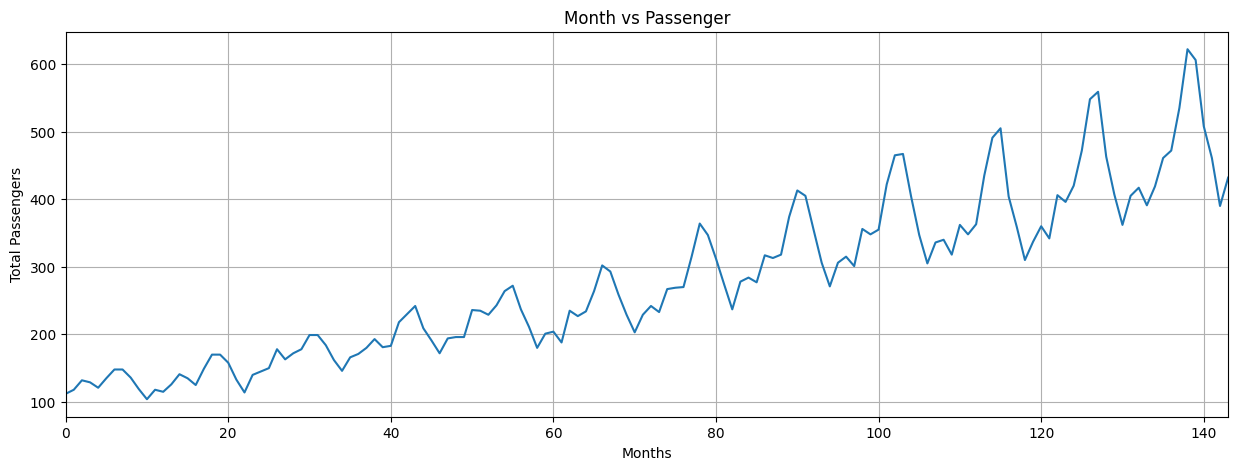

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])


The output shows that over the years the average number of passengers traveling by air increased. 

The number of passengers traveling within a year fluctuates, which makes sense because during summer or winter vacations, the number of traveling passengers increases compared to the other parts of the year.

## 2. Processing the dataset

In [6]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [7]:
# The first preprocessing step is to change the type of the passengers column to float.

all_data = flight_data['passengers'].values.astype(float)

In [8]:
# Now if you print the all_data NumPy array, you should see the following floating type values:

print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


Next, we will divide our data set into training and test sets. 

The LSTM algorithm will be trained on the training set. The model will then be used to make predictions on the test set. The predictions will be compared with the actual values in the test set to evaluate the performance of the trained model.

The first 132 records will be used to train the model and the last 12 records will be used as a test set. The following script divides the data into training and test sets.

In [9]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [10]:
# print their sizes:

print(len(train_data))
print(len(test_data))

132
12


In [11]:
# If you now print the test data, you will see it contains last 12 records from the all_data NumPy array:

print(test_data)


[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


Our dataset is not normalized at the moment. The total number of passengers in the initial years is far less compared to the total number of passengers in the later years. It is very important to normalize the data for time series predictions. 

We will perform min/max scaling on the dataset which normalizes the data within a certain range of minimum and maximum values. We will be using the ```MinMaxScaler``` class from the ```sklearn.preprocessing``` module to scale our data. 

The following code normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [13]:
# Let's check the first and last 5 records of our normalised train data:

print(train_data_normalized[:5],"\n")
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]] 

[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


You can see that the dataset values are now between -1 and 1.

It is important to mention here that <font color='orange'>data normalization is only applied on the training data and not on the test data</font>. If normalization is applied on the test data, there is a chance that some information will be leaked from the training set into the test set.

The next step is to convert our dataset into tensors since PyTorch models are trained using tensors. To convert the dataset into tensors, we can simply pass our dataset to the constructor of the FloatTensor object, as shown below:

In [14]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
print(train_data_normalized)

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385, -0.9516, -0.9033, -0.8374, -0.8637,
        -0.9077, -0.8022, -0.7099, -0.7099, -0.7626, -0.8725, -0.9560, -0.8418,
        -0.8198, -0.7978, -0.6747, -0.7407, -0.7011, -0.6747, -0.5824, -0.5824,
        -0.6484, -0.7451, -0.8154, -0.7275, -0.7055, -0.6659, -0.6088, -0.6615,
        -0.6527, -0.4989, -0.4462, -0.3934, -0.5385, -0.6176, -0.7011, -0.6044,
        -0.5956, -0.5956, -0.4198, -0.4242, -0.4505, -0.3890, -0.2967, -0.2615,
        -0.4154, -0.5297, -0.6659, -0.5736, -0.5604, -0.6308, -0.4242, -0.4593,
        -0.4286, -0.2967, -0.1297, -0.1692, -0.3187, -0.4505, -0.5648, -0.4505,
        -0.3934, -0.4330, -0.2835, -0.2747, -0.2703, -0.0725,  0.1429,  0.0681,
        -0.0857, -0.2527, -0.4154, -0.2352, -0.2088, -0.2396, -0.0637, -0.0813,
        -0.0593,  0.1868,  0.3582,  0.3231,  0.1033, -0.1121, -0.2659, -0.1121,
        -0.0725, -0.1341,  0.1077,  0.07

The final preprocessing step is to convert our training data into sequences and corresponding labels.

You can use any sequence length and it depends upon the domain knowledge. However, in our dataset it is convenient to use a sequence length of 12 since we have monthly data and there are 12 months in a year. 

If we had daily data, a better sequence length would have been 365, i.e. the number of days in a year. Therefore, we will set the input sequence length for training to 12.

In [15]:
train_window = 12

Next, we will define a function named ```create_inout_sequences```. The function will accept the raw input data and will return a list of tuples. 

In each tuple, the first element will contain a list of 12 items corresponding to the number of passengers traveling in 12 months, the second tuple element will contain one item i.e. the number of passengers in the 12+1st month.

In [16]:
def create_inout_sequences(input_data, tw):
    
    inout_seq = []
    L = len(input_data) # this is 132
    
    for i in range(L-tw):
        
        train_seq = input_data[i:i+tw]        # train_seq contains 12 items
        train_label = input_data[i+tw:i+tw+1] # train_label contains the next item i.e. 13th
        
        #print(f"i: {i}, train_seq: {train_seq}, train_label: {train_label}")
        inout_seq.append((train_seq ,train_label))
        #print("tuple:", inout_seq, "\n")
    return inout_seq

In [17]:
# Execute the following script to create sequences and corresponding labels for training:

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [18]:
# Let's now print the first 5 items of the train_inout_seq tuple:

train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

You can see that each item is a tuple where the first element consists of the 12 items of a sequence, and the second tuple element contains the corresponding label.

## 3. Creating an LSTM model

We have preprocessed the data, now is the time to train our model. We will define a class ```LSTM```, which inherits from the ```nn.Module``` class of the PyTorch library. 

In [19]:
class LSTM(nn.Module):
    
    def __init__(self, input_size=1, hidden_layer_size=256, output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

The above code can be explained as follows:

- In the first line, we declare a ```LSTM``` class using PyTorch's ```nn.Module```. In the constructor of the class (the ```__init__()``` method) the following parameters are passed:

1. ```input_size```: Corresponds to the number of features in the input. Though our sequence length is 12, for each month of each of the years we have only 1 value i.e. total number of passengers, therefore the input size will be 1.


2. ```hidden_layer_size```: Specifies the number of hidden layers along with the number of neurons in each layer. We will have one layer of 100 neurons. We can experiment with this parameter as needed


3. ```output_size```: The number of items in the output, since we want to predict the number of passengers for 1 month in the future, the output size will be 1.

The next step is to create an object of the ```LSTM()``` class, define a loss function and the optimizer. Since, we are solving a classification problem, we will use the ```cross entropy loss```. For the optimizer function, we will use the ```Adam Optimizer```.

In [20]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Let's print our model:

print(model)

LSTM(
  (lstm): LSTM(1, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)


## 4. Training the model

In [22]:
epochs = 150

for i in range(epochs):
    
    for seq, labels in train_inout_seq:
        
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00784007
epoch:  26 loss: 0.02081914
epoch:  51 loss: 0.00001834
epoch:  76 loss: 0.00848814
epoch: 101 loss: 0.00058094
epoch: 126 loss: 0.00004961
epoch: 149 loss: 0.0005500081


## 5. Making Predictions

Now that our model is trained, we can start to make predictions. Since our test set contains the passenger data for the last 12 months and our model is trained to make predictions using a sequence length of 12. We will first filter the last 12 values from the training set:

In [23]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist() # select last 12 values from normalized training data
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


Initially the test_inputs item will contain 12 items.

Inside a ```for``` loop these 12 items will be used to make predictions about the first item from the test set i.e. the item number 133. The predicted value will then be appended to the ```test_inputs``` list.

During the second iteration, again the last 12 items will be used as input and a new prediction (for item 134) will be made which will then be appended to the ```test_inputs``` list again.

The ```for``` loop will execute for 12 times since there are 12 elements in the test set. At the end of the loop the ```test_inputs``` list will contain 24 items. 

The last 12 items will be the predicted values for the test set.

In [24]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

If you print the length of the test_inputs list, you will see it contains 24 items. The last 12 predicted items can be printed as follows:

In [25]:
test_inputs[-fut_pred:]

[0.3972802460193634,
 0.45051443576812744,
 0.5966846942901611,
 0.6031241416931152,
 0.6522098779678345,
 0.49764060974121094,
 0.5326212644577026,
 0.4921783208847046,
 0.4766387641429901,
 0.4936143755912781,
 0.4778392016887665,
 0.49127575755119324]

It is important to keep in mind that you may get different values depending upon the weights used for training the LSTM.

Since we normalized the dataset for training, the predicted values are also normalized. We need to convert the normalized predicted values into actual predicted values. We can do so by passing the normalized values to the ```inverse_transform``` method of the min/max scaler object that we used to normalize our dataset.

In [26]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[421.88125597]
 [433.99203414]
 [467.24576795]
 [468.71074224]
 [479.87774724]
 [444.71323872]
 [452.67133766]
 [443.470568  ]
 [439.93531884]
 [443.79727045]
 [440.20841838]
 [443.26523484]]


In [27]:
# Let's now plot the predicted values against the actual values. Look at the following code:

x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


In the script above we create a list that contains numeric values for the last 12 months. The first month has an index value of 0, therefore the last month will be at index 143.

In the following script, we will plot the total number of passengers for 144 months, along with the predicted number of passengers for the last 12 months.

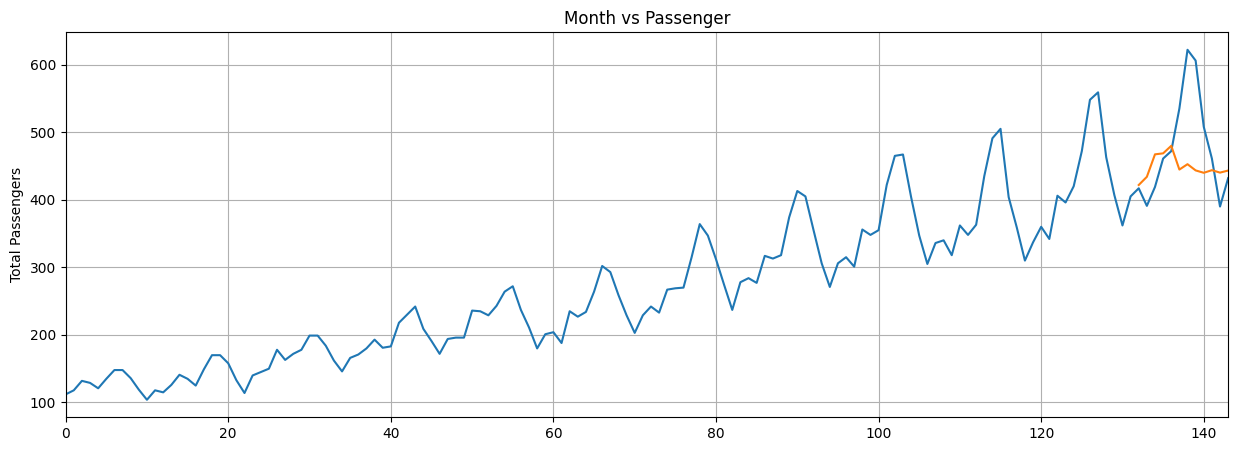

In [28]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

The predictions made by our LSTM are depicted by the orange line. You can see that our algorithm is not too accurate but still it has been able to capture an upward trend for the total number of passengers traveling in the last 12 months along with occasional fluctuations. 

**You can try with a <font color='orange'>greater number of epochs</font> and with a <font color='orange'>higher number of neurons</font> in the LSTM layer to see if you can get better performance.**


To have a better view of the output, we can plot the actual and predicted number of passengers for the last 12 months as follows:

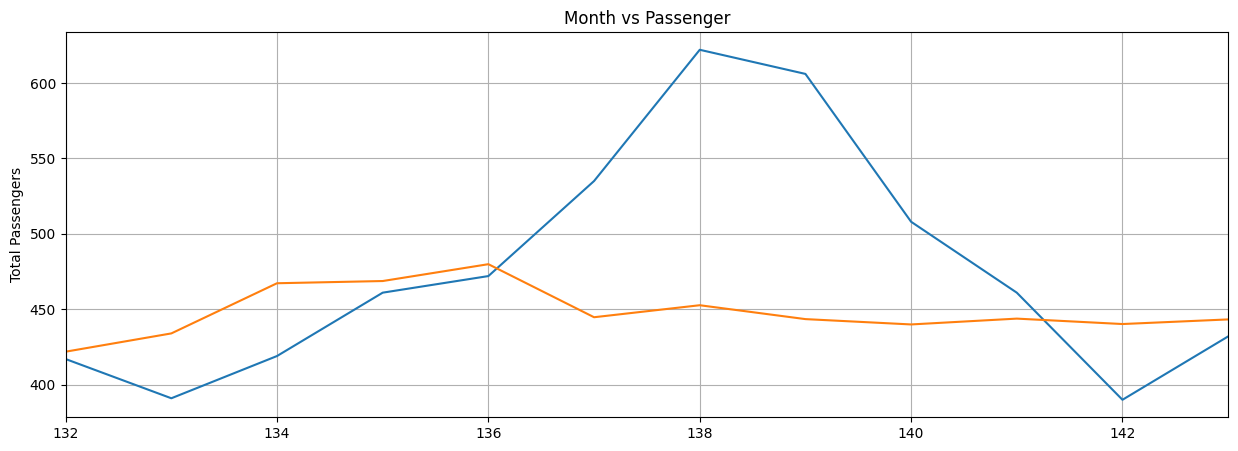

In [29]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

Again, the predictions are not very accurate but the algorithm was able to capture the trend that the number of passengers in the future months should be higher than the previous months with occasional fluctuations.

## 6. Conclusion

LSTM is one of the most widely used algorithms to solve sequence problems. In this article we saw how to make future predictions using time series data with LSTM. You also saw how to implement LSTM with the PyTorch library and then how to plot predicted results against actual values to see how well the trained algorithm is performing.

# Rough Work

In [30]:
train_data_normalized[0:3]

tensor([-0.9648, -0.9385, -0.8769])

In [31]:
a = [1,2,3,4,5]
a[-2:]

[4, 5]